What's New and Changed in version 2.9
--------------------------------------------------------

Enhancement:

    - Constants for directions used in graph functions can be found in `hana_ml.graph.constants.DIRECTION_*`
    - Following functions and objects are now available in `hana_ml.graph` for import
        - `Graph` object
        - `create_graph_from_dataframes` and `create_graph_from_hana_dataframes` factory methods
        - `discover_graph_workspaces`
        - `discover_graph_workspace`
    - The geometries do not need to be to be specified when creating a DataFrame instance anymore. The geometries are analyzed automatically.
    - Support list of targets and trans_param in feature_tool.
    - Enhanced unified report for unified_regression to view feature importance.
    - Enhanced join() to support list of DataFrame.
    - Enhanced union() to support list of DataFrame.
    - Streamlined the `create_dataframe_from_pandas` geo parameters. Now there is only one list of geo_cols, which supports column references as well as (lon, lat) tuples, and one SRID parameter for all columns
    - When you 'create_dataframe_from_pandas' and pass a GeoPandas DataFrame, the geometry column will be detected automatically and processed as a geometry. You don't need to add it manually to `geo_cols`
    - The `Graph` constructor is simplified. You can instantiate a graph simply by the workspace name.

New functions:

    - Introduced `hana_ml.graph.algorithms` which contains all graph algorithms in the future. The package provides a `AlgorithmBase` class which can be used to build additional algorithms for a graph.
    - Add `hana_ml.graph.algorithms.ShortestPath`, which replaces `Graph.shortest_path`
    - Add `hana_ml.graph.algorithms.Neighbors`, which replaces `Graph.neighbors`
    - Add `hana_ml.graph.algorithms.NeighborsSubgraph`, which replaces `Graph.neighbors_with_edges`
    - Add `hana_ml.graph.algorithms.KShortestPaths`
    - Add `hana_ml.graph.algorithms.ShortestPathsOneToAll`
    - Add `hana_ml.graph.discovery.discover_graph_workspace`, which reads the metadata of a graph
    - Add `hana_ml.graph.create_graph_from_edges_dataframe`
    - Add `hana_ml.graph.Graph.has_vertices`, to check if a list of vertices exist in a graph
    - Add `hana_ml.graph.Graph.subgraph`, to create a vertices or edges induced subgraph
    - Add `hana_ml.DataFrame.srids`, which returns the SRS of each geometry column
    - Add `hana_ml.DataFrame.geometries`, which returns the geometry columns if there are any
    - Add `hana_ml.spatial` package, that contains
        - `create_predefined_srs`
        - `is_srs_created`
        - `get_created_srses`
    - Add `hana_ml.docstore` package, that contains
        - `create_collection_from_elements`
    - Added BCPD() for bayesian change point detection.
    - Added shape in dataframe.
    - Added sort_values, sort_index in dataframe.
    - Added scheduler for model renew in model_storage.
    - Added min, max, mean, median, sum, value_counts in dataframe.
    - Added SHAP support for unified regression.
    - Added data lake support in model_storage.
    - Added data lake support in dataframe functions.
    - Added line plot for time seires forecast.
    - Added split_column().
    - Added concat_columns().
    - Added outlier_detection_kmeans(), which detects outliers in datasets based on the result of k-means clustering.
    - Added intermittent_forecast() for forecasting intermittent demand data(time-series).

API change:

    - Removed `geo_cols` from `dataframe.create_dataframe_from_shapefile`
    - Removed `geo_cols` from `ConnectionContext.sql()`
    - Removed `geo_cols` from `ConnectionContext.table()`
    - Removed `Graph.neighbors` and `Graph.neighbors_with_edges`
    - Removed `Graph.shortest_path`
    - Removed `hana_ml.graph.Path`. This is not used anymore
    - Removed `hana_ml.graph.create_hana_graph_from_existing_workspace`. This is replaced by a simplified `Graph` object constructor.
    - Renamed `hana_ml.graph.create_hana_graph_from_vertex_and_edge_frames` to `create_graph_from_dataframes`
    - Changed the type of `geo_cols` in `create_dataframe_from_pandas` to list, which supports direct column references or (lon, lat) tuples for generating POINT geometries

Bug fixes:

    - Fixed inflexible default locations of selected columns of input data, e.g. key, features and endog.
    - Fixed accuracy_measure issue in AutoExponentialSmoothing.
    - Fixed model report's feature importance when it has 0 importance.


### HDL

#### create dl table by create_table

In [1]:
from hana_ml.dataframe import ConnectionContext, create_dataframe_from_pandas

conn = ConnectionContext(address="f98ad2fb-a57e-4bbb-8509-f31b59074da6.hana.canary-eu10.hanacloud.ondemand.com",
                         port=443,
                         user="MLLAB_DL1",
                         encrypt='true',
                         sslValidateCertificate='false')

ModuleNotFoundError: No module named 'shapely'


HANA DB User : MLLAB_DL1 Password : ········


In [2]:
conn.drop_table("DL_TABLE", data_lake=True)
conn.create_table(table="DL_TABLE", table_structure={"A":"INT"}, data_lake=True)

#### create HANA virtual table

In [3]:
conn.drop_table("DL_TABLE")
conn.create_virtual_table(table="DL_TABLE", data_lake_table="DL_TABLE")

#### query virtual table

In [4]:
conn.sql("SELECT * FROM DL_TABLE").collect()

,A


#### drop DL table & HANA virtual table

In [5]:
conn.drop_table("DL_TABLE", data_lake=True)
conn.drop_table("DL_TABLE")

#### copy dataframe to data lake

In [6]:
import pandas as pd

df = create_dataframe_from_pandas(conn, pandas_df=pd.DataFrame({"A": [1,2,3]}), table_name="MY_TABLE", force=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


In [12]:
df.collect()

,A
0,1
1,2
2,3


In [13]:
df.save("DL_TABLE", data_lake=True)

In [14]:
conn.sql("SELECT * FROM DL_TABLE").collect()

,A
0,1
1,2
2,3


In [15]:
conn.drop_table("DL_TABLE", data_lake=True)
conn.drop_table("DL_TABLE")

In [16]:
conn.copy_to_data_lake(df, virtual_table="DL_TABLE", data_lake_table="DL_TABLE", append=False)

In [17]:
conn.sql("SELECT * FROM DL_TABLE").collect()

,A
0,1
1,2
2,3


#### Model Storage in DL

In [2]:
from data_load_utils import DataSets, Settings
from hana_ml.algorithms.pal.model_selection import GridSearchCV
from hana_ml.algorithms.pal.unified_classification import UnifiedClassification
full_tbl, train_tbl, test_tbl, _ = DataSets.load_diabetes_data(conn)
diabetes_train = conn.table(train_tbl)
diabetes_test = conn.table(test_tbl)

uc_hgbdt = UnifiedClassification('HybridGradientBoostingTree')

gscv = GridSearchCV(estimator=uc_hgbdt, 
                    param_grid={'learning_rate': [0.1, 0.4, 0.7, 1],
                                'n_estimators': [4, 6, 8, 10],
                                'split_threshold': [0.1, 0.4, 0.7, 1]},
                    train_control=dict(fold_num=5,
                                       resampling_method='cv',
                                       random_state=1,
                                       ref_metric=['auc']),
                    scoring='error_rate')
gscv.fit(data=diabetes_train, key= 'ID',
         label='CLASS',
         partition_method='stratified',
         partition_random_state=1,
         stratified_column='CLASS',
         build_report=True)
features = diabetes_train.columns
features.remove('CLASS')
features.remove('ID')
pred_res = gscv.predict(diabetes_test, key='ID', features=features)

Table PIMA_INDIANS_DIABETES_TBL exists and data exists


In [6]:
from hana_ml.model_storage import ModelStorage

model_storage = ModelStorage(connection_context=conn)
model_storage.clean_up()
gscv.estimator.name = 'HGBT' 
gscv.estimator.version = 1
model_storage.save_model(model=gscv.estimator, storage_type='HDL')

In [4]:
model_storage.list_models()

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,STORAGE_TYPE,MODEL_STORAGE_VER,SCHEDULE
0,HGBT,1,PAL,hana_ml.algorithms.pal.unified_classification....,"{""model_attributes"": {""kwargs"": {""param_search...",2021-04-14 11:33:39,HDL,1,"{""schedule"": {""status"": ""inactive"", ""schedule_..."


In [5]:
model_storage.delete_model("HGBT", 1)
model_storage.list_models()

,NAME,VERSION,LIBRARY,CLASS,JSON,TIMESTAMP,STORAGE_TYPE,MODEL_STORAGE_VER,SCHEDULE


### Scheduler

In [ ]:
# plan the schedule

model_storage.set_schedule(name='HGBT',
                           version=1,
                           schedule_time='every 3 minutes',
                           connection_userkey='raymondyao',
                           init_params={"func" : 'HybridGradientBoostingTree',
                                        "param_search_strategy" : 'grid',
                                        "resampling_method" : 'cv',
                                        "evaluation_metric" : 'error_rate',
                                        "ref_metric" : ['auc'],
                                        "fold_num" : 5,
                                        "random_state" : 1,
                                        "param_values" : {'learning_rate': [0.1, 0.4, 0.7, 1],
                                                          'n_estimators': [4, 6, 8, 10],
                                                          'split_threshold': [0.1, 0.4, 0.7, 1]}},
                           fit_params={"key" : 'ID',
                                       "label" : 'CLASS',
                                       "partition_method" : 'stratified',
                                       "partition_random_state" : 1,
                                       "stratified_column" : 'CLASS'},
                           training_dataset_select_statement="SELECT * FROM PIMA_INDIANS_DIABETES_TRAIN_VALID_TBL",
                           storage_type='HDL',
                           encrypt='true',
                           sslValidateCertificate='false'
                          )

In [ ]:
model_storage.start_schedule('HGBT', 1)

In [ ]:
model_storage.terminate_schedule('HGBT', 1)

### Use dataframe index

In [29]:
import pandas as pd
df1 = create_dataframe_from_pandas(connection_context=conn,
                                             pandas_df=pd.DataFrame({"ID": [1,2,3],
                                                                     "ID2": [1,2,3],
                                                                     "V1": [2,3,4]}),
                                             table_name="#tt1",
                                             force=True)
df2 = create_dataframe_from_pandas(connection_context=conn,
                                             pandas_df=pd.DataFrame({"ID": [1,2],
                                                                     "ID2": [1,2],
                                                                     "V2": [2,3]}),
                                             table_name="#tt2",
                                             force=True)
df3 = create_dataframe_from_pandas(connection_context=conn,
                                             pandas_df=pd.DataFrame({"ID": [1,2,5],
                                                                     "ID2": [1,2,5],
                                                                     "V3": [2,3,4],
                                                                     "V4": [3,3,3],
                                                                     "V5": ['a','a','b']}),
                                             table_name="#tt3",
                                             force=True)
dfs = [df1.set_index("ID"), df2.set_index("ID"), df3.set_index("ID")]
print(dfs[0].join(dfs[1:]).collect(geometries=False))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


   ID  ID2  V1  ID2  V2  ID2  V3  V4 V5
0   1    1   2    1   2    1   2   3  a
1   2    2   3    2   3    2   3   3  a


In [31]:
df1.sort_index().collect()

,ID,ID2,V1
0,1,1,2
1,2,2,3
2,3,3,4


In [33]:
df1.value_counts().collect()

,VALUES,NUM_ID,NUM_ID2,NUM_V1
0,1,1.0,1.0,NaN
1,2,1.0,1.0,1.0
2,3,1.0,1.0,1.0
3,4,NaN,NaN,1.0


In [7]:
pred_res = gscv.predict(diabetes_test.set_index("ID"), features=features)

### Time Series Visualization

In [9]:
import numpy as np

def geometric_brownian_motion(T = 1, N = 2, mu = -0.01, sigma = 0.001, S0 = 2):        
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N) 
    W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
    X = (mu-0.5*sigma**2)*t + sigma*W 
    S = S0*np.exp(X) ### geometric brownian motion ###
    return S

dates = pd.date_range('2018-03-01', '2018-03-10',freq='H')
T = (dates.max()-dates.min()).days / 365
N = dates.size
start_price = 1000
y = pd.DataFrame()
y['INDEX'] = dates
y['Y'] = geometric_brownian_motion(T, N, sigma=0.1, S0=start_price)

In [11]:
df = create_dataframe_from_pandas(conn, y, '#AMF_TEST', force=True).sort("INDEX")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


In [12]:
train_df = df.filter("DAYS_BETWEEN(INDEX, '2018-03-06') > 0")
test_df = df.filter("DAYS_BETWEEN(INDEX, '2018-03-06') <= 0")

In [13]:
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast

amf = AdditiveModelForecast(growth='linear')
amf.fit(data=train_df)
pred_data = amf.predict(data=test_df)

In [ ]:
# compare prophet

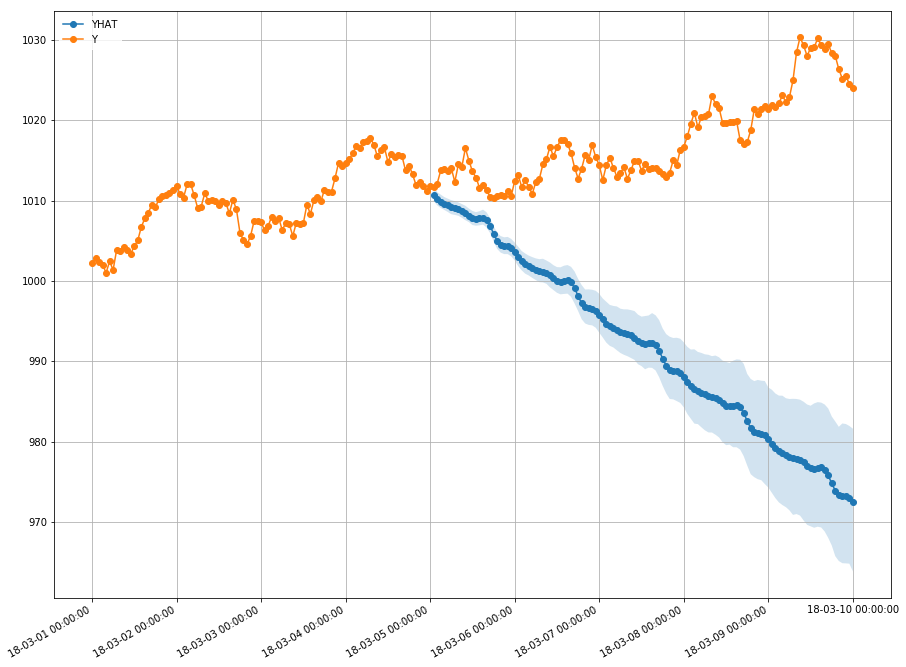

In [14]:
%matplotlib inline

from hana_ml.visualizers.visualizer_base import forecast_line_plot

ax = forecast_line_plot(pred_data=pred_data.set_index("INDEX"),
                        actual_data=df.set_index("INDEX"),
                        confidence=("YHAT_LOWER", "YHAT_UPPER"),
                        max_xticklabels=10)


### Intermittent Time Series Forecast

In [15]:
from hana_ml.algorithms.pal.tsa.intermittent_forecast import intermittent_forecast
output = intermittent_forecast(data=train_df.add_id("ID").deselect("INDEX").set_index("ID"), p=3, forecast_num=3,
                                optimizer='lbfgsb_grid', grid_size=20,
                                optimize_step = 0.011, expost_flag=False,
                                accuracy_measure='mse', ignore_zero=False,
                                thread_ratio=0.5)

In [17]:
output[0].collect()

,ID,Y
0,98,1012.498355
1,99,1012.498355
2,100,1012.498355


### Bayesian Change Point Detection

In [23]:
from hana_ml.algorithms.pal.tsa.changepoint import BCPD
bcpd = BCPD(max_tcp=5, max_scp=5)
tcp, scp, period, components = bcpd.fit_predict(data=train_df.add_id("ID").deselect("INDEX").set_index("ID"), features="Y")

In [27]:
components.head(10).collect()

,ID,SEASONAL,TREND,RANDOM
0,0,0.0,1002.636025,-0.456698
1,1,0.0,1002.792839,0.067509
2,2,0.0,1002.949652,-0.633545
3,3,0.0,1003.106466,-1.061459
4,4,0.0,1003.263279,-2.240881
5,5,0.0,1003.420093,-0.984248
6,6,0.0,1003.576906,-2.191312
7,7,0.0,1003.733720,0.131751
8,8,0.0,1003.890533,-0.190053
9,9,0.0,1004.047347,0.150537
